In [1]:
# importing modules

import pandas as pd
import altair as alt
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import fidap
import config
from shapely import wkt
import statsmodels.api as sm

# instantiating connection 
fidap = fidap.fidap_client(api_key=config.api_key)

### Urban Trees Cover: New York City and San Francisco  
  
The original idea was to look at tree cover in San Francisco as that dataset is more updated than the one in New York City. But then why not look at both?  
  
Some of the questions we can answer include:  
1) What are the spatial and socio-economic distributions of trees within an urban setting?   
2) Are historically under-privileged neighborhoods marginalized even in terms of greenery cover?   
3) Which are some of the oldest trees in these cities?  
4) Can we correlate urban heat island effect with tree cover using existing data? 

In [8]:
# taking a look at sf trees
sf_trees = fidap.sql("""
SELECT tree_id, species, site_info, care_taker, CAST(plant_date AS STRING) AS plant_date, latitude, longitude, ST_GEOGPOINT(longitude, latitude) AS location
FROM bigquery-public-data.san_francisco_trees.street_trees
WHERE latitude IS NOT NULL
AND longitude IS NOT NULL;
""")

# sf neighborhoods
sf_neighborhoods = fidap.sql("""
SELECT neighborhood, neighborhood_geom, ST_AREA(neighborhood_geom)/2589988.1  AS area_sqmi
FROM bigquery-public-data.san_francisco_neighborhoods.boundaries
""")

In [9]:
# converting both queries into gdf
sf_neighborhoods['neighborhood_geom'] = sf_neighborhoods['neighborhood_geom'].apply(wkt.loads) 
sf_neighborhoods_gdf = gpd.GeoDataFrame(sf_neighborhoods, geometry = 'neighborhood_geom', crs = 'epsg:4326')

sf_trees['location'] = sf_trees['location'].apply(wkt.loads)
sf_trees_gdf = gpd.GeoDataFrame(sf_trees, geometry = 'location', crs = 'epsg:4326')

# spatial join of trees to neighborhoods
sf_trees_neighborhood = gpd.sjoin(sf_trees_gdf, sf_neighborhoods_gdf, how = 'inner', op = 'intersects')

# count of trees
sf_trees_neighborhood_count = sf_trees_neighborhood.groupby('neighborhood').agg('count').reset_index()
sf_trees_neighborhood_count = sf_trees_neighborhood_count[['neighborhood', 'tree_id']].rename(columns = {'tree_id': 'n_trees'})

# get density of trees per neighborhood
sf_trees_neighborhood_count = sf_trees_neighborhood_count.merge(sf_neighborhoods[['neighborhood', 'area_sqmi']])
sf_trees_neighborhood_count['density'] = sf_trees_neighborhood_count['n_trees']/sf_trees_neighborhood_count['area_sqmi']

Alternatively, if you do not feel like using `Python` to arrive at the answer, we can do so with `SQL` as well. 

In [ ]:
# SQL alternative to arriving at the density figure
sf_trees_neighborhood_count = fidap.sql("""
WITH trees AS(
SELECT tree_id, ST_GEOGPOINT(longitude, latitude) AS tree_geom
FROM bigquery-public-data.san_francisco_trees.street_trees
WHERE latitude IS NOT NULL
AND longitude IS NOT NULL
), 

sf_neighborhood AS(
SELECT neighborhood, neighborhood_geom, ST_AREA(neighborhood_geom)/2589988.1  AS area_sqmi
FROM bigquery-public-data.san_francisco_neighborhoods.boundaries
)

SELECT COUNT(*) AS n_trees, s.neighborhood, s.area_sqmi , ROUND(COUNT(*)/s.area_sqmi,2) AS tree_density 
FROM trees AS t, sf_neighborhood AS s
WHERE ST_CONTAINS(s.neighborhood_geom, t.tree_geom)
GROUP BY s.neighborhood, s.area_sqmi;
""")

In [ ]:
# visualizing it 
fig, ax = plt.subplots(figsize = (12,9))
sf_trees_neighborhood_gdf.plot(ax = ax, column = 'tree_density', cmap = 'RdYlGn', legend = True, legend_kwds = {'orientation':'horizontal'})
fig.suptitle("Density of Trees in each SF Neighborhood")
ax.set_axis_off()
plt.show()

What if you do not want to see it at the scale of SF neighborhoods? Perhaps Census Tracts are a much better fit for this job as it can contain socio-economic information gathered by the Census Bureau. 

In [26]:
# obtaining boundaries data from SF Open Data Portal
census_tracts_sf_neighborhood = pd.read_csv('https://data.sfgov.org/api/views/nq42-rde6/rows.csv?accessType=DOWNLOAD&bom=true&format=true')

# reading it in as a CSV gives rise to problems as the leading zero is omitted 
census_tracts_sf_neighborhood['GEOID'] = census_tracts_sf_neighborhood.GEOID.astype(str)
census_tracts_sf_neighborhood['GEOID'] = str('0') + census_tracts_sf_neighborhood['GEOID']

# querying for ACS data
census_data = fidap.sql("""
SELECT geo_id, 
total_pop, (black_pop + asian_pop + hispanic_pop + amerindian_pop + other_race_pop) AS non_white_pop, white_pop, 
median_age, income_per_capita
FROM bigquery-public-data.census_bureau_acs.censustract_2018_5yr
WHERE geo_id LIKE '06075%' 
""")

census_data = census_data.assign(
    non_white_pct = lambda x: round(100*x.non_white_pop/x.total_pop,2),
    white_pct = lambda x: round(100*x.white_pop/x.total_pop, 2),
    geo_id = lambda x: str('0') + x.geo_id.astype(str)
)

# merging it with boundaries file from SF Open Data 
census_tracts_data_sf = census_tracts_sf_neighborhood.merge(census_data, how = 'inner', left_on = 'GEOID', right_on = 'geo_id')

# converting it to gdf
census_tracts_data_sf['the_geom'] = census_tracts_data_sf['the_geom'].apply(wkt.loads)
census_tracts_data_sf_gdf = gpd.GeoDataFrame(census_tracts_data_sf, geometry = 'the_geom', crs = 'epsg:4326')
sf_trees_CT_df = gpd.sjoin(sf_trees_gdf, census_tracts_data_sf_gdf, how = 'inner', op = 'intersects')

# aggregating by census tract
sf_trees_CT_count = sf_trees_CT_df.groupby('GEOID').agg('count')
sf_trees_CT_count = sf_trees_CT_count.reset_index()
sf_trees_CT_count = sf_trees_CT_count[['GEOID', 'tree_id']].rename(columns = {'tree_id':'n_trees'})

# getting the geom back 
sf_trees_CT_gdf = census_tracts_data_sf_gdf.merge(sf_trees_CT_count, 'inner', 'GEOID')

# calculating tree density
sf_trees_CT_gdf = sf_trees_CT_gdf[['the_geom', 'GEOID', 'total_pop', 'non_white_pop', 'white_pop', 'median_age', 'income_per_capita', 'non_white_pct', 'white_pct', 'n_trees']]
sf_trees_CT_gdf = sf_trees_CT_gdf.to_crs('epsg:3857')
sf_trees_CT_gdf = sf_trees_CT_gdf.assign(
    area = lambda x: x.geometry.area/2589988.1103,
    tree_density = lambda x: x.n_trees/(x.geometry.area/2589988.1103)
)

Again, you can also stitch all of this together using SQL. 

In [ ]:
sf_trees_CT = fidap.sql("""
WITH sf_CT AS (
SELECT ST_GEOGFROMTEXT(the_geom) AS geometry, NHOOD, CONCAT('0', CAST(GEOID AS STRING)) AS geoid, ST_AREA(ST_GEOGFROMTEXT(the_geom))/2589988.1 AS tract_area
FROM fidap-301014.sf_census_tracts.census_tracts),

trees AS(
SELECT tree_id, ST_GEOGPOINT(longitude, latitude) AS tree_geom, care_taker
FROM bigquery-public-data.san_francisco_trees.street_trees
WHERE latitude IS NOT NULL
AND longitude IS NOT NULL),

private_trees AS (
SELECT s.geoid, COUNT(*) AS n_private_trees
FROM trees AS t, sf_CT as s
WHERE ST_CONTAINS(s.geometry, t.tree_geom)
AND care_taker ='Private'
GROUP BY s.geoid, s.tract_area),

tree_density AS(
SELECT s.geoid, s.tract_area, COUNT(*) AS n_trees, ROUND(COUNT(*)/s.tract_area,2) AS tree_density 
FROM trees AS t, sf_CT AS s
WHERE ST_CONTAINS(s.geometry, t.tree_geom)
GROUP BY s.geoid, s.tract_area),

sf_ct_census AS(
SELECT geo_id, 
total_pop, (black_pop + asian_pop + hispanic_pop + amerindian_pop + other_race_pop) AS non_white_pop, white_pop,
(100*(black_pop + asian_pop + hispanic_pop + amerindian_pop + other_race_pop)/total_pop) AS non_white_pop_pct, (100*white_pop/total_pop) AS white_pop_pct,
median_age, income_per_capita
FROM bigquery-public-data.census_bureau_acs.censustract_2018_5yr
WHERE geo_id LIKE '06075%'
AND total_pop > 0),

sf_trees_ct AS (
SELECT t.geoid, t.tree_density, t.n_trees,
s.total_pop, ROUND(s.total_pop/t.tract_area,2) AS pop_density, s.non_white_pop_pct, s.white_pop_pct, 
s.median_age, s.income_per_capita
FROM sf_ct_census AS s  
INNER JOIN tree_density as t
ON t.geoid = s.geo_id),

sf_trees_ct2 AS(
SELECT sf.geoid, sf.tree_density, sf.n_trees, sf.total_pop, sf.pop_density, sf.non_white_pop_pct,sf.white_pop_pct, sf.median_age, sf.income_per_capita, ct.geometry
FROM sf_trees_ct AS sf
INNER JOIN sf_CT AS ct
ON sf.geoid = ct.geoid)

SELECT * , ROUND (100*pt.n_private_trees/n_trees,2) AS pct_private_trees
FROM sf_trees_ct2 AS sf2
INNER JOIN private_trees AS pt
ON sf2.geoid = pt.geoid;
""")

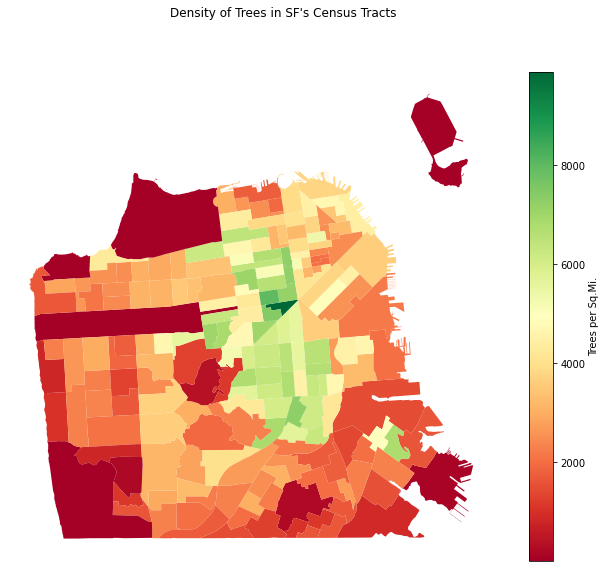

In [29]:
# visualizing it 
fig, ax = plt.subplots(figsize = (12,9))
sf_trees_CT_gdf.plot(ax = ax, column = 'tree_density', 
                     cmap = 'RdYlGn', legend = True, 
                     legend_kwds = {'orientation':'vertical','label':'Trees per Sq.Mi.'})
fig.suptitle("Density of Trees in SF's Census Tracts")
ax.set_axis_off()
plt.show()

In [34]:
trees_income_scatter = alt.Chart(sf_trees_CT_gdf).mark_circle().encode(
    x = 'income_per_capita',
    y = 'tree_density'
)
trees_income_scatter + trees_income_scatter.transform_regression(on = 'income_per_capita', regression = 'tree_density', method = 'linear').mark_line()

alt.LayerChart(...)

What if we run a multiple OLS regression? 

In [56]:
# split
x = sf_trees_CT_gdf[['income_per_capita', 'non_white_pct', 'white_pct']]
y = sf_trees_CT_gdf[['tree_density']]

# running regression
lm = sm.OLS(y, x).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           tree_density   R-squared (uncentered):                   0.809
Model:                            OLS   Adj. R-squared (uncentered):              0.807
Method:                 Least Squares   F-statistic:                              409.4
Date:                Mon, 26 Jul 2021   Prob (F-statistic):                    3.69e-70
Time:                        00:02:12   Log-Likelihood:                         -1734.8
No. Observations:                 195   AIC:                                      3474.
Df Residuals:                     193   BIC:                                      3480.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
income_per_capita     0.0413      0.002     16.714      0.000       0.036       0.046
non_white_pct        15.4429      3.073      5.026      0.000       9.382      21.503
==============================================================================
Omnibus:                        8.256   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.185
Skew:                           0.493   Prob(JB):                       0.0167
Kurtosis:                       3.187   Cond. No.                     1.73e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Okay. So we have established that income and race are significant factors to be taken into account when considering the density of trees in SF's census tracts.  
  
Can we do a spatial regression here?   

In [ ]:
import libpysal as lps
import spreg
from libpysal.weights import Queen, KNN

# Creating spatial weights matrix and regimes
sf_trees_CT_gdf = sf_trees_CT_gdf.rename(columns = {'the_geom':'geometry'})
weights = Queen.from_dataframe(sf_trees_CT_gdf)
weights.transform = "r"
regimes = list(sf_trees_CT_gdf.GEOID)

In [51]:
sp_lm = spreg.GM_Lag(y = np.array(y), x = np.array(x),
                          w = weights, spat_diag = True,
                          name_x = x.columns.tolist(), name_y = 'Tree Density'
                         )

In [54]:
sp_lm = spreg.OLS(y = np.array(y), x = np.array(x),
                          w = weights, spat_diag = True,
                          name_x = x.columns.tolist(), name_y = 'Tree Density'
                         )

In [55]:
print(sp_lm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Tree Density                Number of Observations:         195
Mean dependent var  :   3546.6137                Number of Variables   :           4
S.D. dependent var  :   1953.3537                Degrees of Freedom    :         191
R-squared           :      0.2107
Adjusted R-squared  :      0.1983
Sum squared residual:584292442.043                F-statistic           :     16.9909
Sigma-square        : 3059122.733                Prob(F-statistic)     :   8.001e-10
S.E. of regression  :    1749.035                Log likelihood        :   -1730.702
Sigma-square ML     : 2996371.498                Akaike info criterion :    3469.404
S.E of regression ML:   1731.0030                Schwarz criterion     :    3482.496

----------------------------------------------------------------------------